# Analysing the exterior data to predict house prices

### Pre-process data

In [31]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [32]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics

from sklearn.metrics import mean_squared_error
from math import sqrt

from catboost import CatBoostRegressor, Pool

In [33]:
data = r'/Users/OliverPan/Desktop/house/train.csv'

In [34]:
df = pd.read_csv(data)

In [35]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [36]:
#Defining columns for dataframe
exterior_df = df[['SalePrice', 'LandContour', 'LandSlope', 'Neighborhood', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond']]

In [37]:
exterior_df.head()

,SalePrice,LandContour,LandSlope,Neighborhood,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond
0,208500,Lvl,Gtl,CollgCr,Gable,CompShg,VinylSd,VinylSd,Gd,TA
1,181500,Lvl,Gtl,Veenker,Gable,CompShg,MetalSd,MetalSd,TA,TA
2,223500,Lvl,Gtl,CollgCr,Gable,CompShg,VinylSd,VinylSd,Gd,TA
3,140000,Lvl,Gtl,Crawfor,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA
4,250000,Lvl,Gtl,NoRidge,Gable,CompShg,VinylSd,VinylSd,Gd,TA


#### We can look at the Material Quality, on the outside of the house

Ex = Excellent
Gd = Good
TA = Average/Typical
Fa = Fair
Po = Poor

In [38]:
#The amount per type
exterior_df["ExterQual"].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

Text(0.5, 0.98, 'Sale Price per Exterior Material Quality')

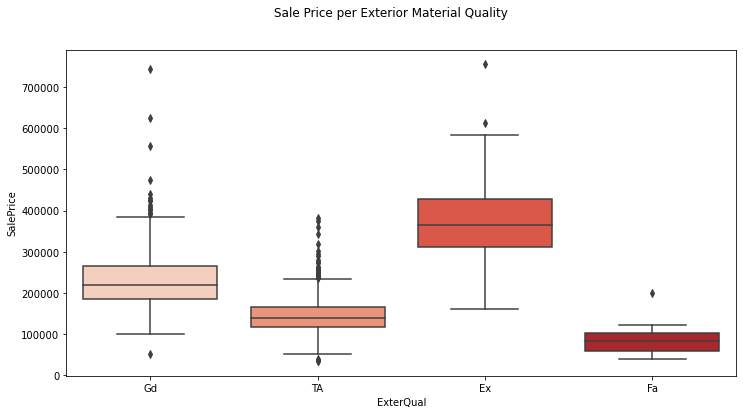

In [49]:
# We can analyze the mean of each one using a boxplot
plt.figure(figsize=(12,6))
sns.boxplot(y = exterior_df["SalePrice"], x = exterior_df["ExterQual"], palette = "Reds")
plt.suptitle("Sale Price per Exterior Material Quality", font)

#### This shows the importance of exterior material quality

In [10]:
#Number of unique values per columns
exterior_df.nunique()

SalePrice       663
LandContour       4
LandSlope         3
Neighborhood     25
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
ExterQual         4
ExterCond         5
dtype: int64

In [12]:
#All the columns are categorical so we can convert them to numerical values for the model
exterior_df["LandContour"] = exterior_df["LandContour"].astype("category").cat.codes
exterior_df["LandSlope"] = exterior_df["LandSlope"].astype("category").cat.codes
exterior_df["Neighborhood"] = exterior_df["Neighborhood"].astype("category").cat.codes
exterior_df["RoofStyle"] = exterior_df["RoofStyle"].astype("category").cat.codes
exterior_df["RoofMatl"] = exterior_df["RoofMatl"].astype("category").cat.codes
exterior_df["Exterior1st"] = exterior_df["Exterior1st"].astype("category").cat.codes
exterior_df["Exterior2nd"] = exterior_df["Exterior2nd"].astype("category").cat.codes
exterior_df["ExterQual"] = exterior_df["ExterQual"].astype("category").cat.codes
exterior_df["ExterCond"] = exterior_df["ExterCond"].astype("category").cat.codes

<ipython-input-12-4fc9af47f870>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exterior_df["LandContour"] = exterior_df["LandContour"].astype("category").cat.codes
<ipython-input-12-4fc9af47f870>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exterior_df["LandSlope"] = exterior_df["LandSlope"].astype("category").cat.codes
<ipython-input-12-4fc9af47f870>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [13]:
#Verify that we have numerical values for model
exterior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     1460 non-null   int64
 1   LandContour   1460 non-null   int8 
 2   LandSlope     1460 non-null   int8 
 3   Neighborhood  1460 non-null   int8 
 4   RoofStyle     1460 non-null   int8 
 5   RoofMatl      1460 non-null   int8 
 6   Exterior1st   1460 non-null   int8 
 7   Exterior2nd   1460 non-null   int8 
 8   ExterQual     1460 non-null   int8 
 9   ExterCond     1460 non-null   int8 
dtypes: int64(1), int8(9)
memory usage: 24.4 KB


### CatBoost

In [15]:
X = exterior_df.drop(["SalePrice"], axis = 1)
y = exterior_df[["SalePrice"]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [17]:
category = ['LandContour', 'LandSlope', 'Neighborhood', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond']

In [18]:
cat_boost = CatBoostRegressor(depth=3, learning_rate=0.1, loss_function='RMSE')
cat_boost.fit(X_train, y_train, cat_features=category)

0:	learn: 75024.9622316	total: 66.6ms	remaining: 1m 6s
1:	learn: 72028.5869583	total: 68.7ms	remaining: 34.3s
2:	learn: 69584.2378239	total: 70.1ms	remaining: 23.3s
3:	learn: 67259.3039806	total: 71.7ms	remaining: 17.8s
4:	learn: 65211.7748345	total: 73.1ms	remaining: 14.6s
5:	learn: 63649.8599629	total: 75.5ms	remaining: 12.5s
6:	learn: 61689.4443414	total: 77.2ms	remaining: 11s
7:	learn: 59766.5672272	total: 78.8ms	remaining: 9.77s
8:	learn: 58070.1851733	total: 80.2ms	remaining: 8.83s
9:	learn: 56710.9400216	total: 81.9ms	remaining: 8.1s
10:	learn: 55659.0520496	total: 83.4ms	remaining: 7.5s
11:	learn: 54519.0085391	total: 84.8ms	remaining: 6.98s
12:	learn: 53643.4557156	total: 86.8ms	remaining: 6.59s
13:	learn: 53019.4881018	total: 88.6ms	remaining: 6.24s
14:	learn: 52365.4961567	total: 90.3ms	remaining: 5.93s
15:	learn: 51859.8186533	total: 91.8ms	remaining: 5.65s
16:	learn: 51391.5308244	total: 93.4ms	remaining: 5.4s
17:	learn: 50939.6393267	total: 94.8ms	remaining: 5.17s
18:	lea

223:	learn: 42841.0633256	total: 433ms	remaining: 1.5s
224:	learn: 42817.9520823	total: 436ms	remaining: 1.5s
225:	learn: 42812.4763391	total: 438ms	remaining: 1.5s
226:	learn: 42808.3005695	total: 441ms	remaining: 1.5s
227:	learn: 42790.9004044	total: 443ms	remaining: 1.5s
228:	learn: 42790.0875102	total: 446ms	remaining: 1.5s
229:	learn: 42784.1737137	total: 449ms	remaining: 1.5s
230:	learn: 42781.9048895	total: 451ms	remaining: 1.5s
231:	learn: 42776.4649930	total: 453ms	remaining: 1.5s
232:	learn: 42775.2505837	total: 456ms	remaining: 1.5s
233:	learn: 42763.5571081	total: 458ms	remaining: 1.5s
234:	learn: 42736.1265177	total: 460ms	remaining: 1.5s
235:	learn: 42729.4083904	total: 462ms	remaining: 1.5s
236:	learn: 42712.2854296	total: 464ms	remaining: 1.49s
237:	learn: 42710.0348383	total: 466ms	remaining: 1.49s
238:	learn: 42701.6093593	total: 468ms	remaining: 1.49s
239:	learn: 42686.4163525	total: 469ms	remaining: 1.49s
240:	learn: 42659.6028237	total: 471ms	remaining: 1.48s
241:	

453:	learn: 40164.5531905	total: 800ms	remaining: 963ms
454:	learn: 40164.2601687	total: 803ms	remaining: 961ms
455:	learn: 40124.0358709	total: 805ms	remaining: 961ms
456:	learn: 40110.9854608	total: 808ms	remaining: 960ms
457:	learn: 40110.3704890	total: 811ms	remaining: 959ms
458:	learn: 40106.3183763	total: 813ms	remaining: 958ms
459:	learn: 40099.8536024	total: 815ms	remaining: 957ms
460:	learn: 40048.7201626	total: 817ms	remaining: 955ms
461:	learn: 40040.9362159	total: 819ms	remaining: 954ms
462:	learn: 40038.0391327	total: 820ms	remaining: 951ms
463:	learn: 40033.8460105	total: 822ms	remaining: 950ms
464:	learn: 40030.5307918	total: 824ms	remaining: 948ms
465:	learn: 40028.3337897	total: 825ms	remaining: 946ms
466:	learn: 40018.0609175	total: 827ms	remaining: 944ms
467:	learn: 40013.1122109	total: 829ms	remaining: 942ms
468:	learn: 40009.1257124	total: 830ms	remaining: 940ms
469:	learn: 39977.8167673	total: 832ms	remaining: 938ms
470:	learn: 39976.3292492	total: 833ms	remaining

668:	learn: 38274.2676754	total: 1.17s	remaining: 581ms
669:	learn: 38268.5988769	total: 1.18s	remaining: 579ms
670:	learn: 38255.3190912	total: 1.18s	remaining: 577ms
671:	learn: 38236.1739739	total: 1.18s	remaining: 576ms
672:	learn: 38231.0461066	total: 1.18s	remaining: 575ms
673:	learn: 38227.1714348	total: 1.19s	remaining: 574ms
674:	learn: 38219.3157170	total: 1.19s	remaining: 573ms
675:	learn: 38215.8166525	total: 1.19s	remaining: 571ms
676:	learn: 38213.9138511	total: 1.2s	remaining: 571ms
677:	learn: 38212.9526049	total: 1.2s	remaining: 570ms
678:	learn: 38202.6644976	total: 1.2s	remaining: 568ms
679:	learn: 38200.3204632	total: 1.21s	remaining: 568ms
680:	learn: 38196.7034092	total: 1.21s	remaining: 567ms
681:	learn: 38196.6102984	total: 1.21s	remaining: 566ms
682:	learn: 38187.9698663	total: 1.22s	remaining: 565ms
683:	learn: 38187.8680356	total: 1.22s	remaining: 563ms
684:	learn: 38183.9829162	total: 1.22s	remaining: 561ms
685:	learn: 38181.1616584	total: 1.22s	remaining: 5

834:	learn: 37270.3112741	total: 1.55s	remaining: 306ms
835:	learn: 37268.1709998	total: 1.55s	remaining: 305ms
836:	learn: 37266.8398236	total: 1.56s	remaining: 304ms
837:	learn: 37253.4942352	total: 1.56s	remaining: 302ms
838:	learn: 37245.7293690	total: 1.57s	remaining: 301ms
839:	learn: 37243.0746262	total: 1.57s	remaining: 299ms
840:	learn: 37233.0119228	total: 1.57s	remaining: 297ms
841:	learn: 37230.5098177	total: 1.57s	remaining: 296ms
842:	learn: 37225.2256562	total: 1.58s	remaining: 294ms
843:	learn: 37222.5767170	total: 1.58s	remaining: 292ms
844:	learn: 37221.9900067	total: 1.58s	remaining: 290ms
845:	learn: 37220.5790537	total: 1.58s	remaining: 288ms
846:	learn: 37218.2833990	total: 1.58s	remaining: 286ms
847:	learn: 37213.1433783	total: 1.59s	remaining: 284ms
848:	learn: 37211.2500138	total: 1.59s	remaining: 283ms
849:	learn: 37209.1533600	total: 1.59s	remaining: 281ms
850:	learn: 37206.1457849	total: 1.59s	remaining: 279ms
851:	learn: 37201.9187389	total: 1.59s	remaining

In [19]:
y_pred = cat_boost.predict(X_test)

In [20]:
#Results using regressor
df = pd.DataFrame({'Actual': y_test["SalePrice"].to_list(), 'Predicted': list(y_pred.flatten())})
df.head()

,Actual,Predicted
0,200624,236960.769734
1,133000,132629.234928
2,110000,123058.141235
3,192000,204084.348366
4,88000,103803.861064


In [21]:
## We should also look at RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

50243.8162308971

In [22]:
## Normalised RMSE
sqrt(mean_squared_error(y_test, y_pred)) / (y_test["SalePrice"].max() - y_test["SalePrice"].min())

0.074105923644391

In [23]:
list(cat_boost.get_feature_importance(Pool(X_test, label = y_test, cat_features=category)))

[1.2835122533473295,
 3.1009698819408307,
 32.62214937360188,
 6.673037642907108,
 2.822641228551309,
 4.494415714904176,
 4.346209810404765,
 42.543348483762145,
 2.1137156105804675]

In [25]:
exterior_df.drop(["SalePrice"], axis = 1).columns.values

array(['LandContour', 'LandSlope', 'Neighborhood', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond'],
      dtype=object)